https://towardsdatascience.com/deep-learning-for-data-integration-46d51601f781

Aim: 
to discover new heterogeneity between cells that's not discovered when looking only at one omic data e.g. only scRNAseq data.


In [1]:
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/UnsupervisedOMICsIntegration/scATACseq.txt
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/UnsupervisedOMICsIntegration/scRNAseq.txt
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/UnsupervisedOMICsIntegration/scBSseq.txt

--2021-07-14 07:11:50--  https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/UnsupervisedOMICsIntegration/scATACseq.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NBISweden/workshop_omics_integration/main/session_ml/UnsupervisedOMICsIntegration/scATACseq.txt [following]
--2021-07-14 07:11:51--  https://raw.githubusercontent.com/NBISweden/workshop_omics_integration/main/session_ml/UnsupervisedOMICsIntegration/scATACseq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3772209 (3.6M) [text/plain]
Saving to: ‘scATACseq.txt’

scATACseq.txt       100%[==================

In [2]:
! pip install umap-learn

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.1MB 17.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=dccc1a801da2d5c45fd164f5ca601067a81ef642806f6277362a985a42f7650d
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=292c0e6a6c54508496b2e51e29042ba10a9d600d575ddacc84ecedf453c0ba9f
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

import keras
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

In [7]:
# dimensional reduction on -omic data 
def plot_pca_tsne_umap_autoencoder(exp_file):
  expr = pd.read_csv(exp_file, sep='\t')
  print("\n" + "Dimensions of input file: " + str(expr.shape) + "\n")
  print("\n" + "A few first lines of input file: " + "\n")
  print(expr.iloc[0:4, 0:4])
  print("\n" + "Last column corresponds to cluster assignments: " + "\n")
  print(expr.iloc[0:4, (expr.shape[1]-4):expr.shape[1]])

  # Log-transform data
  X = expr.values[:, 0:(expr.shape[1] - 1)]
  Y = expr.values[:, expr.shape[1]-1]
  print('\n' + '# of unique cluster labels: ' + '\n')
  print(set(Y))
  print('\n' + 'Log-transforming data...' + '\n')
  X = np.log(X + 1)

  # Dimensionality reduction w/ PCA
  n_input = 20
  x_train = PCA(n_components = n_input).fit_transform(X)
  y_train = Y
  plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, cmap = 'tab10', s = 10)
  plt.title('Principle Component Analysis (PCA)')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()
  print('\n' + 'Dimensions of reduced data set: ' + str(x_train.shape) + '\n')

  # Dimensionality reduction w/ t-SNE
  model_tsne = TSNE(learning_rate=200, n_components=2, random_state=123,
                    perplexity=11, n_iter=1000, verbose=1)
  tsne = model_tsne.fit_transform(x_train)
  plt.scatter(tsne[:, 0], tsne[:, 1], c = y_train, cmap = 'tab10', s = 10)
  plt.title('tSNE on PCA')
  plt.xlabel('tSNE1')
  plt.ylabel('tSNE2')
  plt.show()

  # Dimensionality reduction w/ UMAP
  model_umap = UMAP(n_neighbors=11, min_dist=0.1, n_components=2)
  umap = model_umap.fit_transform(x_train)
  plt.scatter(umap[:, 0], umap[:, 1], c = y_train, cmap = 'tab10', s = 10)
  plt.title('UMAP on PCA')
  plt.xlabel('UMAP1')
  plt.ylabel('UMAP2')
  plt.show()

  # Dimensionality reduction with autoencoder
  model = Sequential()
  model.add(Dense(20,    activation='elu', input_shape=(n_input,)))
  model.add(Dense(10,    activation='elu'))
  model.add(Dense(2,     activation='linear', name="bottleneck"))
  model.add(Dense(10,    activation='elu'))
  model.add(Dense(20,    activation='elu'))
  model.add(Dense(n_input,  activation='sigmoid'))
  model.compile(loss = 'mean_squared_error', optimizer = Adam())
  model.summary()

  history = model.fit(x_train, x_train, batch_size = 16, epochs = 500, shuffle = False, verbose = 1, validation_split = 0.2)
  print("\n" + "Training Accuracy: ", history.history['loss'][-1])
  print("Validation Accuracy: ", history.history['val_loss'][-1])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper right')
  plt.show()

  encoder = Model(model.input, model.get_layer('bottleneck').output)
  bottleneck_representation = encoder.predict(x_train)

  plt.scatter(bottleneck_representation[:,0], bottleneck_representation[:,1], c = y_train, s = 10, cmap = 'tab10')
  plt.title('Autoencoder')
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.show()


Dimensions of input file: (113, 12314)


A few first lines of input file: 

         ENSMUSG00000033845  ...  ENSMUSG00000033793
ESC_A02          557.420060  ...          345.719945
ESC_A03          130.853622  ...          500.541699
ESC_A04          305.735627  ...          195.588448
ESC_A05          417.165580  ...          133.061435

[4 rows x 4 columns]

Last column corresponds to cluster assignments: 

         ENSMUSG00000064367  ENSMUSG00000064368  ENSMUSG00000064370  cluster
ESC_A02         2461.013832           84.509320         3208.793269        1
ESC_A03          177.131122           10.638506           34.575144        1
ESC_A04         2385.149653          123.529546         1689.266543        1
ESC_A05         2227.879975           81.814801         2000.416846        1

# of unique cluster labels: 

{1.0, 2.0, 3.0}

Log-transforming data...



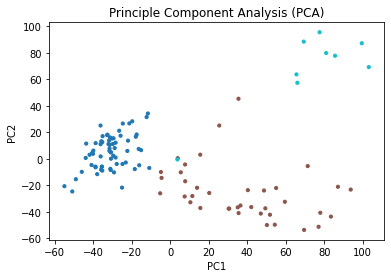


Dimensions of reduced data set: (113, 20)

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.001s...
[t-SNE] Computed neighbors for 113 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 15.364271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.285568
[t-SNE] KL divergence after 1000 iterations: 0.495604


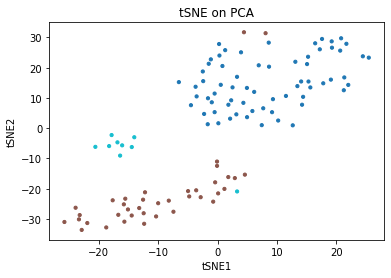

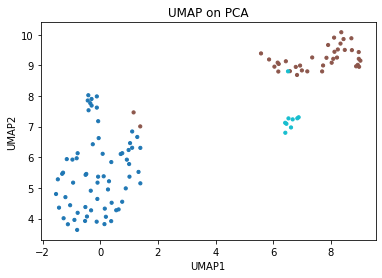

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_8 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
Total params: 1,322
Trainable params: 1,322
Non-trainable params: 0
____________________________________________________

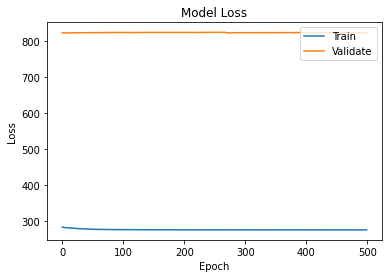

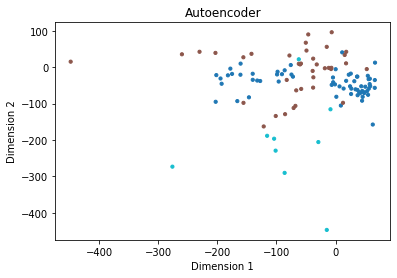

In [8]:
plot_pca_tsne_umap_autoencoder('scRNAseq.txt')


Dimensions of input file: (113, 8575)


A few first lines of input file: 

         1_101606896  1_101935054  1_101935061  1_102002184
ESC_A02            0    88.888889    88.888889        100.0
ESC_A03            0   100.000000   100.000000        100.0
ESC_A04            0   100.000000   100.000000          0.0
ESC_A05            0   100.000000   100.000000          0.0

Last column corresponds to cluster assignments: 

         Y_90826244  Y_90826248  Y_90826260  cluster
ESC_A02       100.0       100.0       100.0        1
ESC_A03       100.0       100.0         0.0        1
ESC_A04       100.0       100.0       100.0        1
ESC_A05       100.0       100.0       100.0        1

# of unique cluster labels: 

{1.0, 2.0, 3.0}

Log-transforming data...



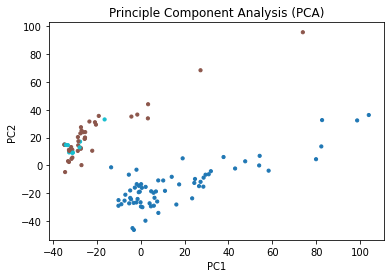


Dimensions of reduced data set: (113, 20)

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.001s...
[t-SNE] Computed neighbors for 113 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 13.869839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.654171
[t-SNE] KL divergence after 1000 iterations: 0.503812


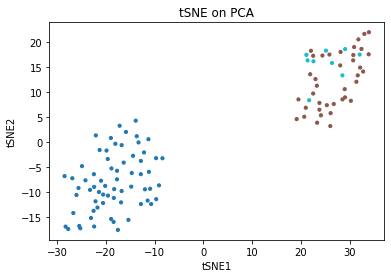

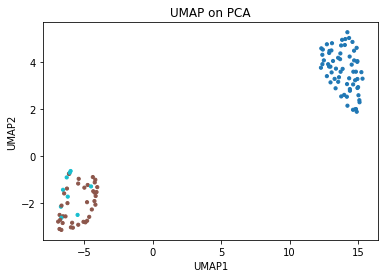

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_12 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_13 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
Total params: 1,322
Trainable params: 1,322
Non-trainable params: 0
____________________________________________________

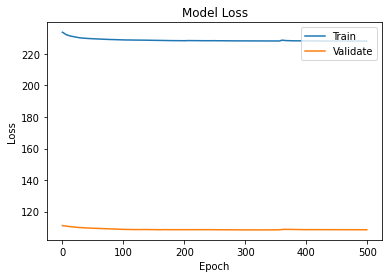

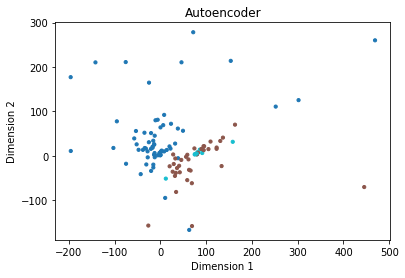

In [9]:
plot_pca_tsne_umap_autoencoder('scBSseq.txt')


Dimensions of input file: (113, 11800)


A few first lines of input file: 

         1_100392139  1_100392151  1_100668590  1_100738967
ESC_A02          100          100           50           83
ESC_A03          100          100           86           88
ESC_A04          100          100           44           83
ESC_A05          100           50           45           83

Last column corresponds to cluster assignments: 

         Y_82121203  Y_90767964  Y_90825443  cluster
ESC_A02           0         100           0        1
ESC_A03           0           0           0        1
ESC_A04          28          38           0        1
ESC_A05          25          50         100        1

# of unique cluster labels: 

{1, 2, 3}

Log-transforming data...



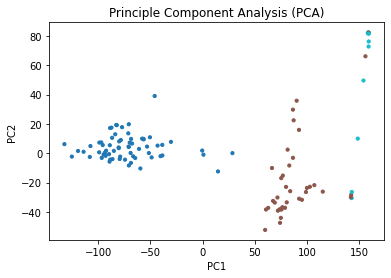


Dimensions of reduced data set: (113, 20)

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.000s...
[t-SNE] Computed neighbors for 113 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 24.140482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.617512
[t-SNE] KL divergence after 1000 iterations: 0.570428


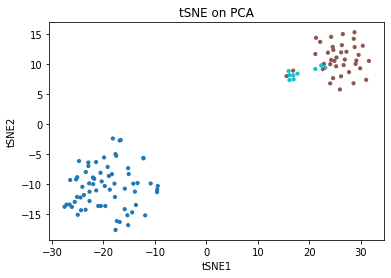

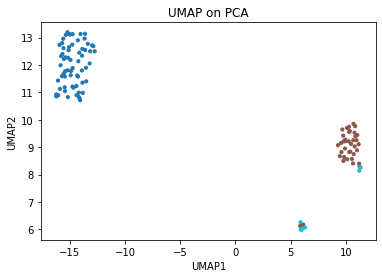

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_17 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_18 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_19 (Dense)             (None, 20)                420       
Total params: 1,322
Trainable params: 1,322
Non-trainable params: 0
____________________________________________________

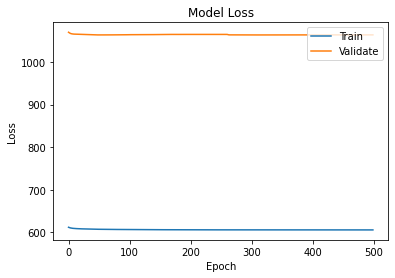

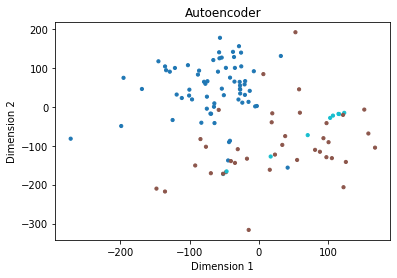

In [11]:
plot_pca_tsne_umap_autoencoder('scATACseq.txt')

# Run Autoencoder on the 3-omics data

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scRNAseq (InputLayer)           [(None, 12313)]      0                                            
__________________________________________________________________________________________________
scBSseq (InputLayer)            [(None, 8574)]       0                                            
__________________________________________________________________________________________________
scATACseq (InputLayer)          [(None, 11799)]      0                                            
__________________________________________________________________________________________________
Dropout_scRNAseq (Dropout)      (None, 12313)        0           scRNAseq[0][0]                   
____________________________________________________________________________________________

TypeError: ignored

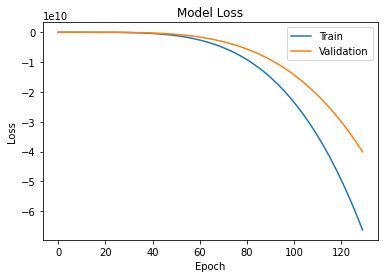

In [12]:
scRNAseq = pd.read_csv('scRNAseq.txt', sep='\t')
scBSseq = pd.read_csv('scBSseq.txt', sep='\t')
scATACseq = pd.read_csv('scATACseq.txt', sep='\t')

X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scBSseq = scBSseq.values[:,0:(scBSseq.shape[1]-1)]
Y_scBSseq = scBSseq.values[:,scBSseq.shape[1]-1]
X_scATACseq = scATACseq.values[:,0:(scATACseq.shape[1]-1)]
Y_scATACseq = scATACseq.values[:,scATACseq.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scBSseq = np.log(X_scBSseq + 1)
X_scATACseq = np.log(X_scATACseq + 1)

# Autoencoder
# Input layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape=(ncol_scRNAseq, ), name='scRNAseq')

ncol_scBSseq = X_scBSseq.shape[1]
input_dim_scBSseq = Input(shape=(ncol_scBSseq, ), name='scBSseq')

ncol_scATACseq = X_scATACseq.shape[1]
input_dim_scATACseq = Input(shape=(ncol_scATACseq, ), name='scATACseq')

encoding_dim_scRNAseq = 30
encoding_dim_scBSseq = 30
encoding_dim_scATACseq = 30

# Dropout input layer
dropout_scRNAseq = Dropout(0.2, name = 'Dropout_scRNAseq')(input_dim_scRNAseq)
dropout_scBSseq = Dropout(0.2, name = 'Dropout_scBSseq')(input_dim_scBSseq)
dropout_scATACseq = Dropout(0.2, name = 'Dropout_scATACseq')(input_dim_scATACseq)

# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation='elu',
                         name = 'Encoder_scRNAseq')(dropout_scRNAseq)
encoded_scBSseq = Dense(encoding_dim_scBSseq, activation='elu',
                         name = 'Encoder_scBSseq')(dropout_scBSseq)
encoded_scATACseq = Dense(encoding_dim_scRNAseq, activation='elu',
                         name = 'Encoder_scATACseq')(dropout_scATACseq) 

# Merging encoder layers from different OMICS
merge = concatenate([encoded_scRNAseq, encoded_scBSseq, encoded_scATACseq])

# Bottleneck compression
bottleneck = Dense(50, kernel_initializer='uniform', activation='linear',
                   name='Bottleneck')(merge)

# Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scBSseq +
                      encoding_dim_scATACseq,
                      activation='elu', name='Concatenate_Inverse')(bottleneck)

# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation='sigmoid',
                         name='Decoder_scRNAseq')(merge_inverse)
decoded_scBSseq = Dense(ncol_scBSseq, activation='sigmoid',
                         name='Decoder_scBSseq')(merge_inverse)
decoded_scATACseq = Dense(ncol_scATACseq, activation='sigmoid',
                         name='Decoder_scATACseq')(merge_inverse)   

# Combining encoder and decoder into an Autoencoder model
autoencoder = Model([input_dim_scRNAseq, input_dim_scBSseq, input_dim_scATACseq],
                    [decoded_scRNAseq, decoded_scBSseq, decoded_scATACseq])

# Compile Autoencoder
autoencoder.compile(optimizer='adam',
                    loss={'Decoder_scRNAseq': 'mean_squared_error',
                          'Decoder_scBSseq': 'binary_crossentropy',
                          'Decoder_scATACseq': 'binary_crossentropy'})

autoencoder.summary()

# Autoencoder training
estimator = autoencoder.fit([X_scRNAseq, X_scBSseq, X_scATACseq], 
                            [X_scRNAseq, X_scBSseq, X_scATACseq], epochs = 130, 
                            batch_size = 16, validation_split = 0.2, 
                            shuffle = True, verbose = 1)
print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])
plt.plot(estimator.history['loss']); plt.plot(estimator.history['val_loss'])
plt.title('Model Loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')



In [13]:
# Encoder model
encoder = Model([input_dim_scRNAseq, input_dim_scBSseq, input_dim_scATACseq], 
                bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scBSseq, X_scATACseq])

Text(0, 0.5, 'UMAP2')

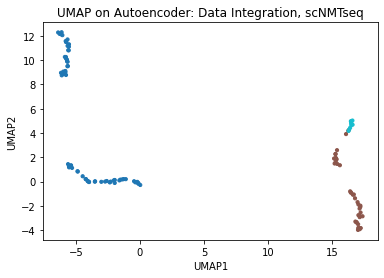

In [14]:
# UMAP on autoencoder bottleneck representation
model_umap = UMAP(n_neighbors = 11, min_dist = 0.1, n_components = 2)
umap = model_umap.fit_transform(bottleneck_representation)
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab10', s = 10)
plt.title('UMAP on Autoencoder: Data Integration, scNMTseq')
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.002s...
[t-SNE] Computed neighbors for 113 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 183113.283232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.178467
[t-SNE] KL divergence after 1000 iterations: 0.096200


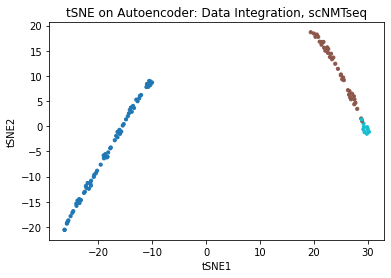

In [15]:
# tSNE on Autoencoder bottleneck representation
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, perplexity = 11, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab10', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, scNMTseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()